## Семинар 8: "LSTM"

ФИО: Богатенкова Анастасия Олеговна

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_packed_sequence
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

https://ru.coursera.org/lecture/machinnoe-obuchenie-v-finansah/riekurrientnyie-nieironnyie-sieti-rnn-sieti-dolghoi-kratkosrochnoi-pamiati-lstm-N08mN

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

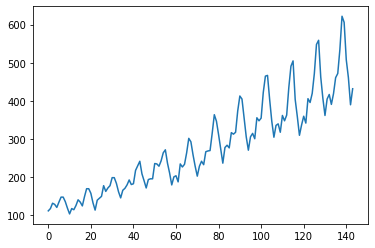

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
# подготавливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size:], dataset[train_size - 30:train_size:] # look_back = 30
print(len(train), len(test))

96 30


In [6]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [7]:
look_back = 30

trainX, trainY = create_dataset(train, look_back)
trainX.shape, trainY.shape

((65, 30), (65,))

In [8]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=30)

### torch.nn.LSTM

In [9]:
# input_size = 1, for each month we have only 1 value i.e. total number of passengers
# hidden_size = 10, specifies the number of hidden layers along with the number of neurons in each layer

class Model_wrapper(nn.Module):

    def __init__(self, model, input_size, hidden_size, output_size=1, num_layers=1):
        super(Model_wrapper, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model = model(self.input_size, self.hidden_size, num_layers)
        self.linear = nn.Linear(self.hidden_size, output_size)

    def forward(self, inp):
        batch_size = inp.size(0)
        self.hidden = (torch.zeros(self.num_layers, batch_size, 
                                   self.hidden_size, requires_grad=True),
                       torch.zeros(self.num_layers, batch_size, 
                                   self.hidden_size, requires_grad=True))
        inp = pack_sequence(inp)
        lstm_out, self.hidden = self.model(inp, self.hidden)
        lstm_out, _ = pad_packed_sequence(lstm_out, False)
        lstm_out = lstm_out[-1]
        y_pred = self.linear(lstm_out.view(batch_size, self.hidden_size))
        return y_pred

In [10]:
lstm_model = Model_wrapper(nn.LSTM, 1, 8)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
num_epochs = 1500
loss_fn = nn.MSELoss()
hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    losses = []
    for X_train, y_train in train_dataloader:
        lstm_model.zero_grad()
        X_train = torch.FloatTensor(X_train).view(-1, look_back, 1)
        y_train = torch.FloatTensor(y_train).view(-1, 1)
        y_pred = lstm_model(X_train)
        loss = loss_fn(y_pred, y_train)
        losses.append(loss.data.item())
        loss.backward()
        optimizer.step()
        hist[epoch] = np.mean(losses)
    if epoch % 100 == 0:
        print('Epoch {}\tMSE {:.3e}'.format(epoch, hist[epoch]))

Epoch 0	MSE 1.287e-02
Epoch 100	MSE 1.589e-03
Epoch 200	MSE 9.798e-04
Epoch 300	MSE 4.153e-04
Epoch 400	MSE 3.685e-04
Epoch 500	MSE 3.940e-04
Epoch 600	MSE 4.263e-04
Epoch 700	MSE 2.939e-04
Epoch 800	MSE 2.689e-04
Epoch 900	MSE 3.182e-04
Epoch 1000	MSE 1.097e-04
Epoch 1100	MSE 4.588e-04
Epoch 1200	MSE 1.127e-04
Epoch 1300	MSE 8.946e-05
Epoch 1400	MSE 9.543e-05


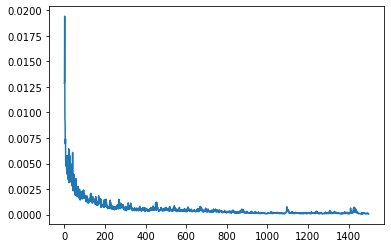

In [11]:
plt.plot(hist)
plt.show()

In [12]:
def predict(model, X_test):
    res = []
    for i in range(test_size):
        y_test = model(X_test)
        res.append(y_test[-1].detach().numpy()[0])
        X_test = torch.cat((X_test[:,1:,:], y_test.view(1, 1, 1)), 1)
    actual=dataset[train_size:len(dataset):]
    plt.plot(actual, label='actual')
    plt.plot(res, label='predicted')
    plt.legend(fontsize=16)
    plt.show()

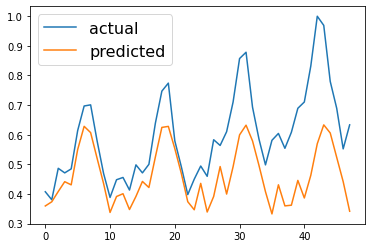

In [13]:
X_test = torch.from_numpy(test).view(1, look_back, 1)
predict(lstm_model, X_test)

### LSTM

In [14]:
class LSTM_wrapper(nn.Module):
    def __init__(self, hidden_size):
        super(LSTM_wrapper, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = LSTM(1, hidden_size)
        self.h2o = nn.Sequential(nn.Linear(hidden_size, 1))

    def forward(self, inp):
        batch_size = inp.size(1)
        hidden = (Variable(torch.zeros(batch_size, self.hidden_size)),
                  Variable(torch.zeros(batch_size, self.hidden_size)))
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out = lstm_out[-1]
        out = self.h2o(lstm_out.view(batch_size, self.hidden_size))
        return out

In [15]:
lstm = LSTM_wrapper(10)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)
scheduler = StepLR(optimizer, 1)
num_epochs = 1000
loss_fn = nn.MSELoss()

for step in range(3):
    for epoch in range(num_epochs):
        losses = []
        for X_train, y_train in train_dataloader:
            lstm.zero_grad()
            X_train = Variable(X_train.permute(1,0).unsqueeze(-1))
            y_train = Variable(y_train)
            y_pred = lstm(X_train).squeeze()
            loss = loss_fn(y_pred, y_train)
            losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            print('Epoch {}\tMSE {:.3e}'.format(epoch, np.mean(losses)))
    scheduler.step()

Epoch 0	MSE 9.385e-02
Epoch 100	MSE 2.466e-03
Epoch 200	MSE 1.815e-03
Epoch 300	MSE 1.816e-03
Epoch 400	MSE 1.801e-03
Epoch 500	MSE 1.787e-03
Epoch 600	MSE 2.423e-03
Epoch 700	MSE 1.819e-03
Epoch 800	MSE 2.029e-03
Epoch 900	MSE 1.026e-03
Epoch 0	MSE 6.508e-04
Epoch 100	MSE 5.904e-04
Epoch 200	MSE 6.337e-04
Epoch 300	MSE 6.482e-04
Epoch 400	MSE 5.499e-04
Epoch 500	MSE 5.890e-04
Epoch 600	MSE 4.851e-04
Epoch 700	MSE 4.011e-04
Epoch 800	MSE 3.249e-04
Epoch 900	MSE 3.970e-04
Epoch 0	MSE 2.641e-04
Epoch 100	MSE 2.519e-04
Epoch 200	MSE 2.961e-04
Epoch 300	MSE 2.153e-04
Epoch 400	MSE 1.897e-04
Epoch 500	MSE 2.466e-04
Epoch 600	MSE 2.421e-04
Epoch 700	MSE 2.275e-04
Epoch 800	MSE 2.075e-04
Epoch 900	MSE 2.063e-04


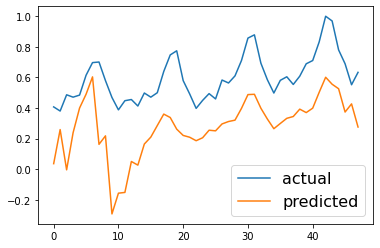

In [16]:
X_test = torch.from_numpy(test).view(look_back, 1, 1)
res = []
for i in range(test_size):
    y_test = lstm(X_test)
    res.append(y_test[-1].detach().numpy()[0])
    X_test = torch.cat((X_test[1:,:,:], y_test.view(1, 1, 1)), 0)
actual=dataset[train_size:len(dataset):]
plt.plot(actual, label='actual')
plt.plot(res, label='predicted')
plt.legend(fontsize=16)
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: